In [2]:
import numpy as np
import scipy as sp
import pandas as pd
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import linalg as LA

import time

import logistic_regression as LR
import first_order_method as FOM

import sys
sys.path.insert(0, '/Users/HKim/Desktop/Research/Experiments/libsvm-weights-3.20/python')
from svm import *
from svmutil import *

In [3]:
xx = pd.read_csv('../dataset/original/dataset_statistics.csv')
xx

,file name,# samples (before removing empty rows),# samples (after removing empty rows),# features,classes,# classes,normalized,sparse,comment
0,news20.binary,19996,19954,1355191,"[1.0, -1.0]",2,1,1,NaN
1,covtype.libsvm.binary,581012,581012,54,"[1.0, 2.0]",2,0,1,NaN
2,covtype.libsvm.binary.scale,581012,581012,54,"[1.0, 2.0]",2,0,1,Different from covtype.binary: every feature i...
3,real-sim,72309,72201,20958,"[1.0, -1.0]",2,1,1,NaN
4,rcv1_train.binary,20242,20242,47236,"[1.0, -1.0]",2,1,1,NaN
5,rcv1_test.binary,677399,677399,47236,"[1.0, -1.0]",2,1,1,NaN


In [4]:
def compute_2norm_row(X):
    X_tmp = X.copy()
    X_tmp.data **= 2
    norm_y = sp.sqrt(X_tmp.sum(1))
    return sp.sqrt(X_tmp.sum(1))

In [5]:
def normalize_row(X):
    row_norm = compute_2norm_row(X)
    return sp.sparse.diags([1.0/n[0] for n in row_norm])*X

In [6]:
def data_parsing(X,y):
#     # Removing empty data
#     empty_idx = []
#     for i in xrange(len(X)):
#         if len(X[i].keys()) == 0:
#             empty_idx.append(i)
#             continue
#     n_deleted = 0
#     for idx in empty_idx:
#         del X[idx-n_deleted]
#         del y[idx-n_deleted]
#         n_deleted += 1

    # The number of samples
    n_samples = len(X)

    # Feature dimension
    dim = max([max(xi.keys()) for xi in X])
    
    # Convert from dictionary to a scipy sparse row matrix
    XX = sp.sparse.dok_matrix((n_samples,dim), dtype=float)
    for i in xrange(len(X)):
        for key, value in X[i].iteritems():
            XX[i,key-1] = value
    XX = XX.tocsr()
    
    # Normalize feature vectors
#     XX = normalize_row(XX)
    return XX, y

In [7]:
# def main():
# Read the data
y_trn, X_trn = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_train.binary')
# y_tst, X_tst = svm_read_problem('/Users/HKim/Desktop/Research/Experiments/dataset/rcv1_test.binary')

In [8]:
X_trn, y_trn = data_parsing(X_trn, y_trn)
# X_tst, y_tst = data_parsing(X_tst, y_tst)

# The number of samples
n_sample = X_trn.shape[0]

In [9]:
# Define the problem: setting the paramters of logistic regression
data = {'X_train':X_trn, 'y_train':y_trn}#, 'X_test': X_tst, 'y_test': y_tst}
parameters = {"lambda":2.0/n_sample}

In [10]:
param_method = {"step-size":1e-3, "# max-pass":10, "epsilon":1e-3,
                "result_stored":{'trn_loss':True,'tst_loss':False,'trn_err':True,'tst_err':False,
                                 'norm_grad':True,'n_grad_comp':True}}

In [11]:
# Generate the problem: Logistic-regression
problem = LR.BinaryLogisticRegression(data, parameters)

tic = time.time()
param_method['step-size'] = 10
# Full gradient
fgd = FOM.FirstOrderMethod(problem, 'fgd', param_method)
# Do optimization
fgd.do_optimization()
# print fgd.get_result("trn_loss")
print time.time()-tic

0.353339195251


In [13]:
# Generate the problem: Logistic-regression
problem = LR.BinaryLogisticRegression(data, parameters)

tic = time.time()
param_method['step-size'] = 5e-1
# SVRG (m=n/2)

svrg = []
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample())
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/2)
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/4)
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/8)

epoch_sizes = ['n','n/2','n/4','n/8']
svrg = dict(zip(epoch_sizes, svrg))
# Do optimization
for _key_ in epoch_sizes:
    tic = time.time()
    svrg[_key_].do_optimization()
    print 'epoch size:', _key_, time.time()-tic

epoch size: n 418.151708841
epoch size: n/2 211.268537998
epoch size: n/4 135.703274012
epoch size: n/8 67.4810228348


In [16]:
# Generate the problem: Logistic-regression
problem = LR.BinaryLogisticRegression(data, parameters)

tic = time.time()
param_method['step-size'] = 5e-1
# SVRG (m=n/2)

svrg = []
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample())
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/2)
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/4)
problem = LR.BinaryLogisticRegression(data, parameters)
svrg.append(FOM.FirstOrderMethod(problem, 'svrg', param_method))
svrg[-1].set_epoch_size(problem.get_n_sample()/8)

epoch_sizes = ['n','n/2','n/4','n/8']
svrg = dict(zip(epoch_sizes, svrg))
# Do optimization
for _key_ in epoch_sizes:
    tic = time.time()
    svrg[_key_].do_optimization()
    print 'epoch size:', _key_, time.time()-tic

epoch size: n 488.535475969
epoch size: n/2 245.836379051
epoch size: n/4 155.847065926
epoch size: n/8 71.856924057


In [243]:
# Reshape Update History --> pandas dataframe

update_history = []
gd_history = [('Algorithm', ['GD' for i in fgd.results[fgd.results.keys()[0]]])]
for key2, val2 in fgd.results.iteritems():
    if len(val2): # check if the item is empty or not
        if key2 is 'n_grad_comp':
            key_tmp = 'effective pass'
            val_tmp = [i/float(n_sample) for i in val2]
        else:
            key_tmp = key2
            val_tmp = val2
        gd_history += [(key_tmp,val_tmp)]

# gd_history += [(key,val) for key,val in fgd.results.iteritems() if len(val)]
update_history.append(('GD', pd.DataFrame.from_items(gd_history)))

for key in epoch_sizes:
    val = svrg[key]
    svrg_history = [('Algorithm', ['SVRG (m='+key+')' for i in val.results[val.results.keys()[0]]])]
    for key2, val2 in val.results.iteritems():
        if len(val2): # check if the item is empty or not
            if key2 is 'n_grad_comp':
                effective_pass = [i/float(n_sample) for i in val2]
                svrg_history += [('effective pass',effective_pass)]
                
                # Start computation for PIM
                # Compute # of gradient computations when the computations of full gradient is not taken into account.
                val2
                effective_pass = []
                nn = 0
                for _n_grad_comp_ in val2:
                    effective_pass.append((_n_grad_comp_+nn)/float(n_sample))
                    nn -= n_sample
                # End computation for PIM
                svrg_history += [('effective pass (PIM)',effective_pass)]
            else:
                key_tmp = key2
                val_tmp = val2
                svrg_history += [(key_tmp,val_tmp)]
    update_history.append(('svrg ('+key+')', pd.DataFrame.from_items(svrg_history)))
    
update_history = dict(update_history)

In [258]:
update_history[update_history.keys()[4]]
# update_history.keys()
# update_history[update_history.keys()[1]]
# update_history[update_history.keys()[2]]
# update_history[update_history.keys()[3]]
# update_history[update_history.keys()[4]]

,Algorithm,trn_err,norm_grad,trn_loss,effective pass,effective pass (PIM)
0,SVRG (m=n/2),0.481721,0.030613,0.693147,0.0,0.0
1,SVRG (m=n/2),0.061852,0.014041,0.422295,1.5,0.5
2,SVRG (m=n/2),0.054985,0.008253,0.340234,3.0,1.0
3,SVRG (m=n/2),0.051774,0.005444,0.304212,4.5,1.5
4,SVRG (m=n/2),0.047080,0.003789,0.285255,6.0,2.0
5,SVRG (m=n/2),0.045302,0.002647,0.275089,7.5,2.5
6,SVRG (m=n/2),0.042091,0.002018,0.269909,9.0,3.0
7,SVRG (m=n/2),0.041547,0.001702,0.267366,10.5,3.5


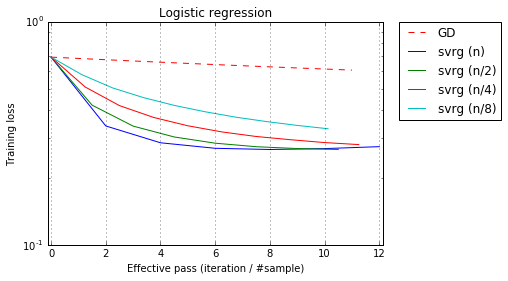

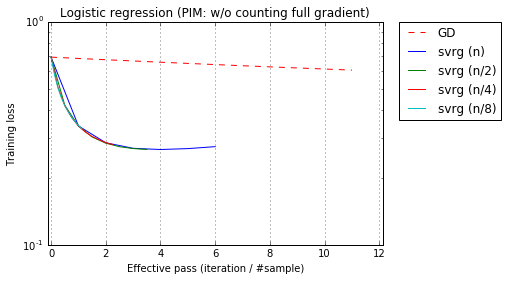

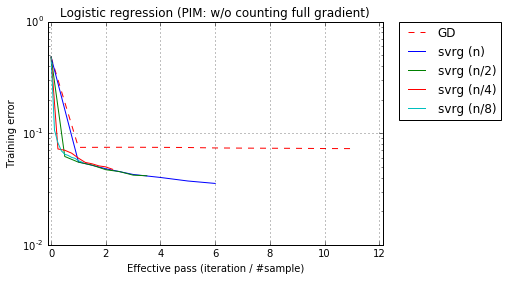

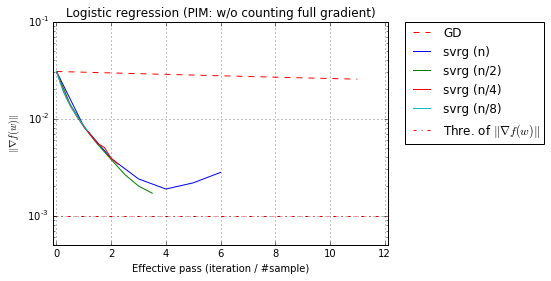

In [270]:
pass_max = max([i['effective pass'].values[-1] for i in update_history.values()])

# Loss
_result_ = 'trn_loss'
plt.figure()
plt.semilogy(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.semilogy(update_history[_key_]['effective pass'], update_history[_key_][_result_], label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.grid()
plt.title('Logistic regression')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training loss')

# Loss (PIM)
_result_ = 'trn_loss'
plt.figure()
plt.semilogy(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.semilogy(update_history[_key_]['effective pass (PIM)'], update_history[_key_][_result_], label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training loss')


# Classification error
_result_ = 'trn_err'
plt.figure()
plt.semilogy(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.semilogy(update_history[_key_]['effective pass (PIM)'], update_history[_key_][_result_], label=_key_)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel('Training error')


# Norm of gradient
_result_ = 'norm_grad'
plt.figure()
plt.semilogy(update_history['GD']['effective pass'], update_history['GD'][_result_], 'r--', label='GD')
for m in ['n','n/2','n/4','n/8']:
    _key_ = 'svrg ('+m+')'
    plt.semilogy(update_history[_key_]['effective pass (PIM)'], update_history[_key_][_result_], label=_key_)
plt.semilogy([-0.01*pass_max, 1.01*pass_max],
         [param_method['epsilon'],param_method['epsilon']], 'r-.',label=r'Thre. of $\| \nabla f(w) \|$')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(-0.01*pass_max, 1.01*pass_max)
plt.ylim(bottom=param_method['epsilon']/2)
plt.grid()
plt.title('Logistic regression (PIM: w/o counting full gradient)')
plt.xlabel('Effective pass (iteration / #sample)')
plt.ylabel(r'$\| \nabla f(w) \|$')

In [ ]:
param_method['step-size'] = 1e-4
# Stochastic gradient
sgd = FOM.FirstOrderMethod(problem, 'sgd', param_method)
# Do optimization
sgd.do_optimization()

In [43]:
if __name__ == '__main__':
    main()

In [26]:
fgd.results

{'n_grad_comp': [0,
  20242,
  40484,
  60726,
  80968,
  101210,
  121452,
  141694,
  161936,
  182178,
  202420,
  222662],
 'norm_grad': [0.030613451312589628,
  0.03008507692876905,
  0.029569467017598338,
  0.029066692991126443,
  0.028576747317357803,
  0.028099554293978608,
  0.027634980356983238,
  0.027182843711322225,
  0.026742923147662651,
  0.02631496597342594,
  0.02589869503698005,
  0.025493814861938909],
 'trn_err': [0.48172117379705565,
  0.074646774034186347,
  0.074745578500148208,
  0.074844382966110068,
  0.074646774034186347,
  0.074449165102262627,
  0.07375753384052959,
  0.07351052267562494,
  0.073312913743701219,
  0.073164707044758429,
  0.072868293646872834,
  0.072769489180910973],
 'trn_loss': [0.69314718055994529,
  0.68385635277805279,
  0.67488293100762209,
  0.66621387122443043,
  0.6578364928533923,
  0.64973851434310304,
  0.64190807902509983,
  0.63433377242729949,
  0.6270046322221513,
  0.61991015195109089,
  0.61304027959317575,
  0.6063854119